In [1]:
from osgeo import gdal
import fiona
import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio as rio
#from rasterstats import zonal_stats

from nansat import Nansat
from nansat import *

from s1denoise import Sentinel1Image
from s1denoise import *

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

import matplotlib as mpl

In [2]:
# Define path locations
s1_path = '/container_dir1/subsets/S1B_IW_GRDH_1SDV_20210716T054037_20210716T054102_027815_0351B0_E546.zip'
s2_path = '/container_dir1/subsets/Subset_S2_20210716_resampled.tif'
src_awei = '/container_dir1/subsets/AWEI_S2B_MSIL2A_20210716.tif'
src_ndwi = '/container_dir1/subsets/NDWI_S2B_MSIL2A_20210716.tif'
src_vis = '/container_dir1/subsets/VIs_Subset_S2B_MSIL2A_20210716.tif'

In [3]:
# Open files
s1 = Nansat(s1_path)
ndwi = Nansat(src_ndwi)
awei = Nansat(src_awei)
raw_bands_s2 = Nansat(s2_path)
vis = Nansat(src_vis)

02:32:59|40|nansat|_get_dataset_metadata|GDAL could not open /container_dir1/subsets/S1B_IW_GRDH_1SDV_20210716T054037_20210716T054102_027815_0351B0_E546.zip, trying to read with Nansat mappers...


In [4]:
#Reproject the S1 data to S2
n = gdal.Open(s2_path)
d = Domain(ds=n)
s1.reproject(d)

In [5]:
# Stack as multi-dimensional np array
all_bands = [raw_bands_s2[band_n] for band_n in raw_bands_s2.bands().keys()]
all_bands.append(ndwi[1])
all_bands.append(awei[1])
for band_n in vis.bands().keys():
    all_bands.append(vis[band_n])

In [6]:
all_bands

[array([[157, 183, 193, ...,  77,   1,   3],
        [201, 183, 182, ...,   1,   1,   1],
        [201, 190, 209, ...,   1,  19,   6],
        ...,
        [199, 170, 226, ..., 138, 167, 267],
        [187, 214, 227, ..., 152, 144, 157],
        [188, 223, 244, ..., 148, 141, 164]], dtype=uint16),
 array([[335, 320, 355, ..., 243, 137, 116],
        [367, 334, 335, ..., 147, 112, 141],
        [414, 357, 380, ..., 152, 135, 148],
        ...,
        [382, 386, 403, ..., 512, 620, 713],
        [400, 396, 421, ..., 577, 598, 588],
        [390, 404, 438, ..., 565, 532, 526]], dtype=uint16),
 array([[284, 273, 315, ..., 333, 101, 101],
        [299, 284, 297, ..., 140,  88,  72],
        [315, 311, 317, ..., 139, 114, 108],
        ...,
        [181, 182, 191, ..., 190, 253, 339],
        [183, 189, 213, ..., 173, 200, 240],
        [183, 205, 238, ..., 243, 258, 274]], dtype=uint16),
 array([[1009, 1019,  930, ..., 2156, 2342, 1924],
        [1098, 1072, 1046, ..., 1954, 1986, 1914],
 

In [ ]:
all_bands.append(s1[8])

In [9]:
all_bands.append(s1[10])

In [10]:
bands_stack = np.array(all_bands)

# Check the shape of the array, should have 15 layers - 6 optical bands, 7 indices and 2 SAR-bands
bands_stack.shape

(19, 1091, 960)

In [55]:
## Export with Rasterio, because GDAL is a pain
with rio.open(s2_path) as src5:
    transform = src5.transform
affine = transform
crs = rio.crs.CRS.from_epsg(32632)

meta = {'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': bands_stack.shape[2],
 'height': bands_stack.shape[1],
 'count': bands_stack.shape[0],
 'crs': crs,
 'transform': affine}

with rio.open('/container_dir1/results/all_bands.tif', 'w', **meta) as dst:
    for band_nr, src in enumerate(bands_stack, start=1):
        dst.write_band(band_nr, src) 

In [67]:
### Mask land with aoi shapefile
from rasterio.mask import mask

with fiona.open('/container_dir1/subsets/aoi.shp') as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rio.open('/container_dir1/results/all_bands.tif') as src4:
    out_image, transformed = mask(src4, shapes, crop=True, filled=True)
    out_meta = src4.meta

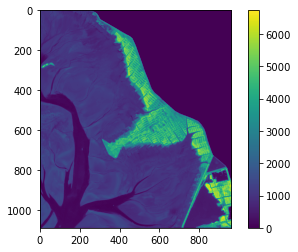

In [68]:
# Check if masking worked
plt.imshow(out_image[3]);plt.colorbar()

In [97]:
#Extract the pixel values of VIs & Bands at training points:
# Import shapefile table with labels
src_t_points = '/container_dir1/subsets/t_points_new2.shp'
points = gpd.read_file(src_t_points)
class_names = points['classtxt'].unique()
print(class_names)
points.head()

['water' 'structures' 'seabed' 'lsm' 'pioneer' 'usm']


,id,classid,classtxt,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,geometry
0,None,1,water,0,0,0,0.000000,42.297056,8.784622,54.564908,POINT (486073.904 6046397.927)
1,None,1,water,1,0,1,9.984770,42.297056,8.784725,54.564975,POINT (486080.623 6046405.312)
2,None,1,water,2,0,2,19.969540,42.297056,8.784829,54.565041,POINT (486087.343 6046412.697)
3,None,1,water,3,0,3,29.954310,42.297056,8.784933,54.565108,POINT (486094.062 6046420.083)
4,None,1,water,4,0,4,39.939081,42.297056,8.785036,54.565175,POINT (486100.782 6046427.468)


In [109]:
### open the raster 
coord_list = [(x,y) for x,y in zip(points['geometry'].x , points['geometry'].y)]
with rio.open('/container_dir1/results/all_bands.tif') as sava: 
    samplevalues = [x for x in sava.sample(coord_list)]
    
B2 = [i[0] for i in samplevalues] 
B3 = [i[1] for i in samplevalues]
B4 = [i[2] for i in samplevalues]
B8 = [i[3] for i in samplevalues]
B11 = [i[4] for i in samplevalues]
B12 = [i[5] for i in samplevalues]
NDWI = [i[6] for i in samplevalues] 
AWEI = [i[7] for i in samplevalues]
NDVI = [i[8] for i in samplevalues] 
SAVI = [i[9] for i in samplevalues]
MSAVI = [i[10] for i in samplevalues] 
NDMI = [i[11] for i in samplevalues]
EVI = [i[12] for i in samplevalues] 
S0_VH = [i[13] for i in samplevalues]
S0_VV = [i[14] for i in samplevalues] 

points['B2']=B2
points['B3']=B3
points['B4']=B4
points['B8']=B8
points['B11']=B11
points['B12']=B12
points['NDWI']=NDWI
points['AWEI']=AWEI
points['NDVI']=NDVI
points['SAVI']=SAVI
points['MSAVI']=MSAVI
points['NDMI']=NDMI
points['EVI']=EVI
points['S0_VH']=NDMI
points['S0_VV']=EVI

points.columns
points.head()

,id,classid,classtxt,vertex_ind,vertex_par,vertex_p_1,distance,angle,x,y,...,B12,NDWI,AWEI,NDVI,SAVI,MSAVI,NDMI,EVI,S0_VH,S0_VV
0,None,1,water,0,0,0,0.000000,42.297056,8.784622,54.564908,...,140,0,0,0,2,0,0,0,0,0
1,None,1,water,1,0,1,9.984770,42.297056,8.784725,54.564975,...,145,0,0,0,2,0,0,0,0,0
2,None,1,water,2,0,2,19.969540,42.297056,8.784829,54.565041,...,145,0,0,0,2,0,0,0,0,0
3,None,1,water,3,0,3,29.954310,42.297056,8.784933,54.565108,...,148,0,0,0,2,0,0,0,0,0
4,None,1,water,4,0,4,39.939081,42.297056,8.785036,54.565175,...,144,0,0,0,2,0,0,0,0,0


In [110]:
# create new working gdf with only the interesting columns and without the qgis stuff in original table
points2 = points[['classid', 'classtxt', 'geometry', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']].copy()
points2

### Problem: decimals don´t get imported.... -.-

,classid,classtxt,geometry,B2,B3,B4,B8,B11,B12,NDWI,AWEI,NDVI,SAVI,MSAVI,NDMI,EVI,S0_VH,S0_VV
0,1,water,POINT (486073.904 6046397.927),248,360,200,139,167,140,0,0,0,2,0,0,0,0,0
1,1,water,POINT (486080.623 6046405.312),255,365,225,141,161,145,0,0,0,2,0,0,0,0,0
2,1,water,POINT (486087.343 6046412.697),236,366,248,159,161,145,0,0,0,2,0,0,0,0,0
3,1,water,POINT (486094.062 6046420.083),203,391,240,135,165,148,0,0,0,2,0,0,0,0,0
4,1,water,POINT (486100.782 6046427.468),257,387,238,158,155,144,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14140,5,lsm,POINT (489238.936 6051398.693),168,402,293,2182,994,475,0,0,0,2,0,0,0,0,0
14141,5,lsm,POINT (489231.804 6051405.338),176,392,260,2364,1026,492,0,0,0,2,0,0,0,0,0
14142,5,lsm,POINT (489224.672 6051411.984),181,427,246,2352,1026,492,0,0,0,2,0,0,0,0,0
14143,5,lsm,POINT (489217.540 6051418.630),148,405,237,2276,1013,493,0,0,0,2,0,0,0,0,0


In [71]:
### Export geodataframe as trainingpoints for classification
points2.to_file('/container_dir1/results/gdf_train_pixelvalues.shp', mode='w')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


ValueError: Invalid field type <class 'numpy.ndarray'>

In [111]:
points2.columns

Index(['classid', 'classtxt', 'geometry', 'B2', 'B3', 'B4', 'B8', 'B11', 'B12',
       'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH',
       'S0_VV'],
      dtype='object')

In [112]:
# Drop classes seabed and structures for now, because we only want a binary classification AND the tides of S1 and S2 do not go together - so drop 
# pioneer saltmarsh as well, because this is water in S1 and vegetation in S2/VIs...
points2 = points2[(points2.classtxt != 'seabed') & (points2.classtxt != 'structures') & (points2.classtxt != 'pioneer')]

In [118]:
class_names2 = points2['classtxt'].unique()
print(class_names2)

['water' 'usm']


In [165]:
points2.loc[(points2.classid == '5'), 'v'] = '6'

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [120]:
# Start splitting training points into train and test data set
# Convert points2 to a normal pandas dataframe, because there is a np array somewhere in there and it causes problems
df = pd.DataFrame(points2)
cols = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']
X_train, X_test, y_train, y_test=train_test_split(df[cols], df['classid'], train_size=0.7, random_state=42)
X_train
print(y_train)

13656      usm
11927    water
7319     water
8762       usm
14047      usm
         ...  
9259       usm
13203      usm
13238      usm
13581      usm
860      water
Name: classtxt, Length: 4034, dtype: object


In [121]:
### Normal classification without scaling, fitting the classifier
clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=50)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=50)

In [122]:
clf_classified = clf.predict(X_test)

['water' 'water' 'water' ... 'usm' 'water' 'water']


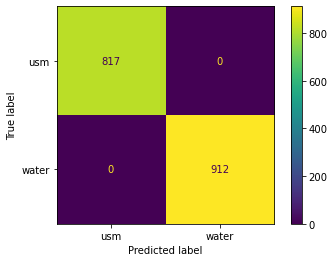

,usm,water,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,817.0,912.0,1.0,1729.0,1729.0


In [125]:
### Accuracy scores
#scores = cross_val_score(clf, X_test, y_train.values, cv=5)
#scores

#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# classification = clf_classified.reshape((rows, cols))

print(clf_classified)
#build confusion matrix (x-axis: predicted pixels, y-axis: reference pixels; class 1,2,3,4,5)
cm = confusion_matrix(y_test.values, clf_classified, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report

#calculate number of pixels that were classified correctly
accuracy_score(y_test, clf_classified, normalize=False)
pd.DataFrame(classification_report(y_test, clf_classified, digits=2, output_dict=True))

In [127]:
### Save the model

joblib.dump(clf, '/container_dir1/results/RFC_all_data.joblib')
loaded_clf = joblib.load('/container_dir1/results/RFC_all_data.joblib')

# loaded_clf.predict(X_test)
loaded_clf.predict(X_test)

array(['water', 'water', 'water', ..., 'usm', 'water', 'water'],
      dtype=object)

In [128]:
clf_classified

array(['water', 'water', 'water', ..., 'usm', 'water', 'water'],
      dtype=object)

TypeError: Image data of dtype <U5 cannot be converted to float

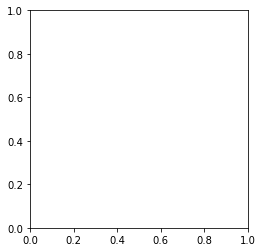

In [164]:
# Check if masking worked


In [138]:
out_image.shape

(15, 1091, 960)

In [160]:
clf_classified.shape
#???

(1729,)

In [156]:
### Apply to more original stack
keys = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'AWEI', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'S0_VH', 'S0_VV']
arr_flat = [out_image[i, :, :].flatten() for i in range(out_image.shape[0])]
# returns a list instead of a flattened array?????

In [157]:
arr_flat = np.array(arr_flat)

In [158]:
arr_flat.shape

(15, 1047360)

In [162]:
raster_df = pd.DataFrame(arr_flat, {
    "B2" : arr_flat[0],
    "B3" : arr_flat[1],
    "B4" : arr_flat[2],
    "B8" : arr_flat[3],
    "B11" : arr_flat[4],
    "B12" : arr_flat[5],
    "NDWI" : arr_flat[6],
    "AWEI" : arr_flat[7],
    "NDVI" : arr_flat[8],
    "SAVI" : arr_flat[9],
    "MSAVI" : arr_flat[10],
    "NDMI" : arr_flat[11],
    "EVI" : arr_flat[12],
    "S0_VH" : arr_flat[13],
    "S0_VV" : arr_flat[14]})
cols_raster_df = raster_df.columns

#show length of raster data frame to check number
len(raster_df.columns)

1047360

In [161]:
#show if it worked and all the column-names are correct and in the correct order in the raster data frame
raster_df
raster_df.columns

RangeIndex(start=0, stop=1047360, step=1)

In [ ]:
#classify the raster
raster_pred = clf.predict(raster_df)
#reshape from array to raster
#take shape from original raster
shape_out = (arr.shape[1], arr.shape[2])
print(shape_out)
#show shape from original raster: 2-dimensional (correct? multidimensional?)
shape_out

#final calssified raster is the classified raster but reshaped in the shape as the original --> multidimensional
raster_out = raster_pred.reshape(shape_out)
print(raster_out.shape)

### Output path
output = path + 'RF_Sep_Classification.tif'
output
#define output data type (same as original)
meta["dtype"] = 'float32'
meta["count"] = 1

#test if it worked
meta
with rasterio.open(output, 'w', **meta) as dst:
    dst.write(raster_out, 1)
    
raster_out